In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import EfficientSU2, TwoLocal, ZZFeatureMap
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.result import QuasiDistribution
from qiskit.transpiler.passes import Decompose
from qiskit.quantum_info import Operator

from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit_algorithms import VQE, NumPyMinimumEigensolver, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA, GradientDescent, Optimizer, Minimizer
from qiskit_algorithms.gradients import  ParamShiftEstimatorGradient #, FiniteDiffEstimatorGradient, LinCombEstimatorGradient, QFI, DerivativeType, LinCombQGT

from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider, YahooDataProvider

from qiskit.primitives import BackendSampler, StatevectorEstimator, StatevectorSampler
from qiskit.primitives import Estimator
from qiskit_aer.primitives import Sampler

#Aer Sim

from scipy.optimize import minimize
from docplex.mp.model import Model
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings

In [22]:
# Filters warnings into critical and non-crital
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#Necessary for tracking convergence
estimator = Estimator()
sampler = StatevectorSampler()
optimizer = COBYLA()
converter = QuadraticProgramToQubo()

# Gradient decsent methods
grad_pshift = ParamShiftEstimatorGradient(estimator) 

In [23]:
# set number of assets which is equal to number of qubits
num_assets = 10
seed = 479  # To keep consistently generated data

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider( # Change to YahooDataProvider for real stock data
    tickers=stocks,
    start=datetime.datetime(2023, 1, 1),
    end=datetime.datetime(2023, 1, 30),
    seed=seed,
)

data.run()
ev = data.get_period_return_mean_vector() # Initial state to optimize over


risk_factor = 0.5  # set risk factor
budget = 5  # set budget (number of assets to keep)

qp = PortfolioOptimization(expected_returns=ev, covariances=covariance, risk_factor=risk_factor, budget=budget).to_quadratic_program()
qubo = converter.convert(qp) #constraintless format to pass as operator

In [24]:
# 3 common quantum circuits to use for ansatz with linear entanglement
ZZ_linear = ZZFeatureMap(feature_dimension=num_assets, entanglement='linear', reps=1)
SU2_linear = EfficientSU2(num_assets, entanglement='linear', reps=1)
TwoL_linear = TwoLocal(num_assets, 'ry', 'cx', entanglement='linear', reps=1)

# 3 common quantum circuits to use for ansatz with cyclic entanglement
ZZ_cyclic = ZZFeatureMap(feature_dimension=num_assets, entanglement='circular', reps=1) 
SU2_cyclic = EfficientSU2(num_assets, entanglement='circular', reps=1)
TwoL_cyclic = TwoLocal(num_assets, 'ry', 'cx', entanglement='circular', reps=1)


# 3 common quantum circuits to use for ansatz with full entanglement
ZZ_full = ZZFeatureMap(feature_dimension=num_assets, entanglement='full', reps=1)
SU2_full = EfficientSU2(num_assets, entanglement='full', reps=1)
TwoL_full = TwoLocal(num_assets, 'ry', 'cx', entanglement='full', reps=1)


# master list for ansatz circuits 
ansatz_list = [[ZZ_linear, ZZ_cyclic, ZZ_full],
                [SU2_linear, SU2_cyclic, SU2_full],
                [TwoL_linear, TwoL_cyclic, TwoL_full]]


# This starts the optimization considering all assets with equal weight
ZZ_params = [0.1] * num_assets    # ZZFeatureMap circuit has the same as the number of assets parameters,
SU2_params = [0.1] * num_assets * 4  # EfficentSU2 circuit has the same as the number of assets times 4 parameters
TwoL_params = [0.1] * num_assets * 2  # TwoLocal circuit has the double the number of assets parameters

In [25]:
step = 0.1 # Naive step amount
H, vec = qubo.to_ising() # Extract Unitary Transformed Hamiltonian 

In [26]:
# Standard Gradient descent method
def gd(init_params, iterations, H, step, qc_list):
    params = [[init_params], [init_params], [init_params]]
    for i in range(iterations):
        grad_lin = grad_pshift.run([qc_list[0]], [H], [params[0][i]]).result().gradients[0] 
        params[0].append(params[0][i] - step * grad_lin)
        
        grad_cyc = grad_pshift.run([qc_list[1]], [H], [params[1][i]]).result().gradients[0] 
        params[1].append(params[1][i] - step * grad_cyc)
        
        grad_full = grad_pshift.run([qc_list[2]], [H], [params[2][i]]).result().gradients[0] 
        params[2].append(params[2][i] - step * grad_full)
        #step = step * .75 # Modification to decay the step distance
    return params

# Estimate the energy level and progression toward a ground state
def estimate_energies(p, params, H, qc):
    if qc == "ZZ":
        qc1 = ZZFeatureMap(feature_dimension=num_assets, entanglement='linear', reps=p)
        qc2 = ZZFeatureMap(feature_dimension=num_assets, entanglement='circular', reps=p)
        qc3 = ZZFeatureMap(feature_dimension=num_assets, entanglement='full', reps=p)
    elif qc == "SU2":
        qc1 = EfficientSU2(num_assets, entanglement='linear', reps=p)
        qc2 = EfficientSU2(num_assets, entanglement='circular', reps=p)
        qc3 = EfficientSU2(num_assets, entanglement='full', reps=p)
    else:
        qc1 = TwoLocal(num_assets, 'ry', 'cx', entanglement='linear', reps=p)
        qc2 = TwoLocal(num_assets, 'ry', 'cx', entanglement='circular', reps=p)
        qc3 = TwoLocal(num_assets, 'ry', 'cx', entanglement='full', reps=p)     
    
    qc = [qc1, qc2, qc3]
    i=0
    ans = [[], [], []]
    for param in params:
        ans[i] = [estimator.run([qc[i]], [H], pair).result().values[0] for pair in param]
        i += 1 
    return ans

# Plots the energy level at each iteration of gradient descent to show convergence 
def plot_energies(p, params, H, qc):
    if qc == "ZZ": 
        e = estimate_energies(p, params, H, "ZZ")
    elif qc == "SU2":
        e = estimate_energies(p, params, H, "SU2")
    else:
        e = estimate_energies(p, params, H, "TwoL")
    n = len(e[0])
    labels = ['linear', 'cyclic', 'full']
    for i, s in enumerate(e):
        plt.scatter(np.arange(n), s, label=labels[i])
    plt.title(f'Convergence Analysis for $H$ with {qc}, Naive $\mu={step}$')
    plt.legend(loc=1)
    plt.ylabel('Estimated Energy')
    plt.xlabel('Iteration')
    plt.show()

In [27]:
### Only uncomment when ready to analyze convergence ###
ZZ_result = gd(ZZ_params, 25, H, step, ansatz_list[0])

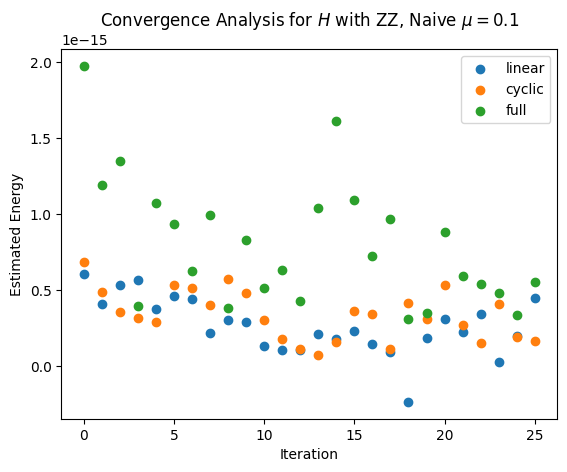

In [28]:
plot_energies(1, ZZ_result, H, "ZZ")

In [29]:
SU2_result = gd(SU2_params, 25, H, step, ansatz_list[1])

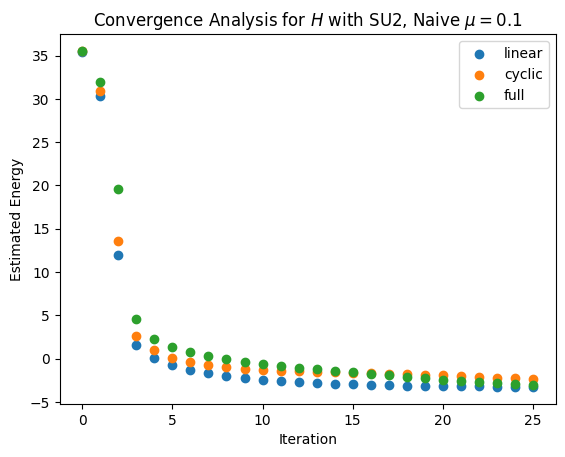

In [30]:
plot_energies(1, SU2_result, H, "SU2")

In [31]:
TwoL_result = gd(TwoL_params, 25, H, step, ansatz_list[2])

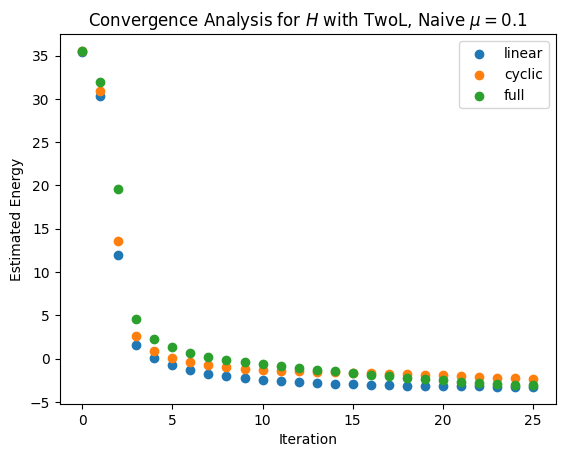

In [32]:
plot_energies(1, TwoL_result, H, "TwoL")

In [33]:
print(SU2_result[0][25])

[ 2.64609588e-07 -4.01850864e-05  2.66263480e-03  4.48985492e-01
  2.12317577e+00  1.80258465e+00  2.06128183e+00  1.84302648e+00
  1.75695393e+00  1.61905146e+00  9.96768151e-02  9.90213915e-02
  9.79905114e-02  8.55998880e-02  3.79637618e-02  8.86462454e-03
  2.25877163e-02  1.50210728e-02  1.04716486e-02  2.13831683e-03
  3.41282337e-02  3.07630523e-02 -4.94275710e-03 -2.57485253e-01
  7.02772941e-01  5.42417752e-01  4.82393408e-01  8.49663532e-01
  9.09941180e-01  1.39132174e+00  1.00000000e-01  1.00000000e-01
  1.00000000e-01  1.00000000e-01  1.00000000e-01  1.00000000e-01
  1.00000000e-01  1.00000000e-01  1.00000000e-01  1.00000000e-01]


In [36]:
# Plug in any ansatz to use VQE or the fastest performing one based convergence rate
num_assets = 25
budget = 20
SU2_linear = EfficientSU2(num_assets, entanglement='linear', reps=1)
best_ansatz = SU2_linear #placeholder till we know which one is the best circuit for this task

seed = 479  # To keep consistently generated data

# Generate expected return and covariance matrix from (random) time-series
stocks = [("TICKER%s" % i) for i in range(num_assets)]
data = RandomDataProvider( # Change to YahooDataProvider for real stock data
    tickers=stocks,
    start=datetime.datetime(2023, 1, 1),
    end=datetime.datetime(2023, 1, 30),
    seed=seed,
)

data.run()
ev = data.get_period_return_mean_vector() # Initial state to optimize over
covariance = data.get_period_return_covariance_matrix() # Hamiltonian Matrix

qp = PortfolioOptimization(expected_returns=ev, covariances=covariance, risk_factor=risk_factor, budget=budget).to_quadratic_program()
svqe = MinimumEigenOptimizer(SamplingVQE(sampler=Sampler(), ansatz=best_ansatz, optimizer=optimizer))
result = svqe.solve(qp)

In [37]:
# Print the optimal portfolio based on budget and risk 
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )

    # Prints all the options for portfolio and their vale
    print("\n----------------- Full result ---------------------")
    print("This is a list of all possible porfolio options and their valuation:")
    print("\n\t\t selection\t\t\t\t value\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = qp.objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))


print_result(result)

Optimal: selection [1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1.
 1.], value 0.0285

----------------- Full result ---------------------
This is a list of all possible porfolio options and their valuation:

		 selection				 value		probability
---------------------------------------------------
[1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1]	0.1352		0.0039
[1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1]	0.2122		0.0029
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1]	0.1013		0.0029
[1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1]	0.2088		0.0029
[1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1]	0.2108		0.0029
[1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1]	0.0958		0.0029
[1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1]	0.2184		0.0029
[1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1]	0.0973		0.0029
[1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1]	0.1291		0.0029
[1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1]	0.1101		0.0029
[1 1 1 1